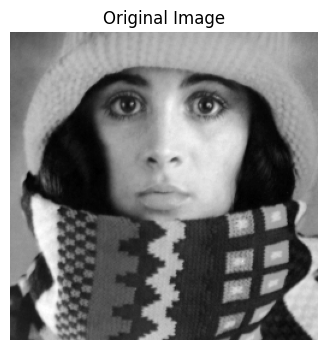

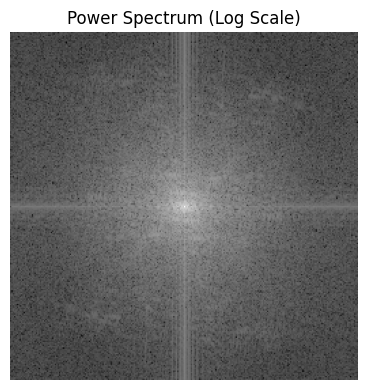

In [2]:
#3.1
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio
import scipy.fft


def compute_power_spectrum(image):
    """
    Compute the power spectrum of an image using 2D Fourier Transform.
    """
    fft_image = scipy.fft.fft2(image)  # Compute 2D FFT
    fft_shifted = scipy.fft.fftshift(fft_image)  # Shift zero frequency to center
    power_spectrum = np.log(1 + np.abs(fft_shifted))  # Log scale for better visualization
    return power_spectrum


image = iio.imread("../TestImages/Week 1/trui.png")

power_spectrum = compute_power_spectrum(image)

fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.imshow(image, cmap="gray")
ax1.set_title("Original Image")
ax1.axis("off")

fig, ax2 = plt.subplots(figsize=(8, 4))

ax2.imshow(power_spectrum, cmap="gray")
ax2.set_title("Power Spectrum (Log Scale)")
ax2.axis("off")

plt.tight_layout()
plt.show()


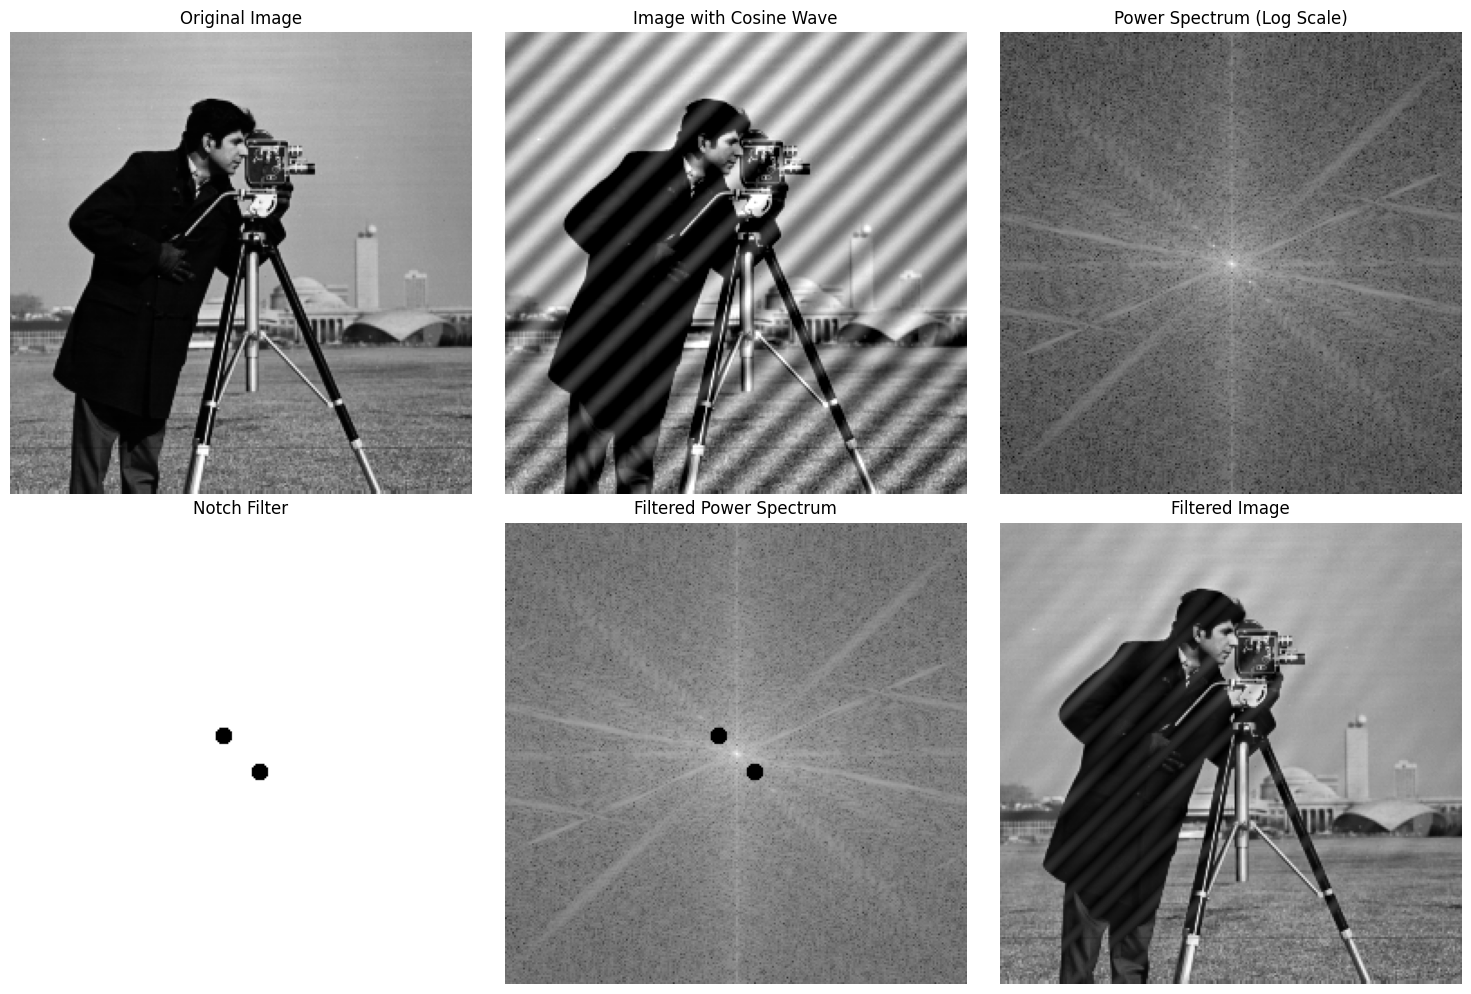

In [4]:
#3.2
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio
from scipy.fft import fft2, fftshift, ifft2

# Load the original image
image = iio.imread("../TestImages/Week 1/cameraman.tif")

# Generate cosine wave interference
def add_cosine_wave(image, a0=50, v0=10, w0=10):
    """ Add a cosine wave interference to the image: a0 * cos(v0*x + w0*y) """
    H, W = image.shape
    x = np.arange(W)
    y = np.arange(H)
    X, Y = np.meshgrid(x, y)

    wave = a0 * np.cos(2 * np.pi * (v0 * X / W + w0 * Y / H))  # Normalize frequency
    noisy_image = np.clip(image + wave, 0, 255)  # Ensure pixel values remain in [0, 255]
    return noisy_image.astype(np.uint8)

noisy_image = add_cosine_wave(image)

# Compute the Fourier Transform
F_noisy = fft2(noisy_image)
F_noisy_shifted = fftshift(F_noisy)  # Shift the zero-frequency component to the center
power_spectrum = np.log(1 + np.abs(F_noisy_shifted))  # Compute the power spectrum (log scale)

# Design a notch filter to remove interference
def notch_filter(shape, v0, w0, radius=5):
    """ Create a notch filter to attenuate frequencies at (v0, w0) and its symmetric point """
    H, W = shape
    X, Y = np.meshgrid(np.arange(W), np.arange(H))
    X = X - W // 2
    Y = Y - H // 2
    D1 = np.sqrt((X - v0) ** 2 + (Y - w0) ** 2)
    D2 = np.sqrt((X + v0) ** 2 + (Y + w0) ** 2)
    H = np.ones((H, W))
    H[D1 < radius] = 0  # Suppress frequency at (v0, w0)
    H[D2 < radius] = 0  # Suppress frequency at (-v0, -w0)
    return H

notch = notch_filter(image.shape, v0=10, w0=10)
F_filtered = F_noisy_shifted * notch  # Apply the filter
filtered_image = np.abs(ifft2(fftshift(F_filtered)))  # Compute the inverse Fourier transform

# Visualization
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Display the original image
axs[0, 0].imshow(image, cmap='gray')
axs[0, 0].set_title("Original Image")
axs[0, 0].axis("off")

# Display the image with cosine wave interference
axs[0, 1].imshow(noisy_image, cmap='gray')
axs[0, 1].set_title("Image with Cosine Wave")
axs[0, 1].axis("off")

# Display the power spectrum
axs[0, 2].imshow(power_spectrum, cmap='gray')
axs[0, 2].set_title("Power Spectrum (Log Scale)")
axs[0, 2].axis("off")

# Display the notch filter
axs[1, 0].imshow(notch, cmap='gray')
axs[1, 0].set_title("Notch Filter")
axs[1, 0].axis("off")

# Display the filtered power spectrum
filtered_spectrum = np.log(1 + np.abs(F_filtered))
axs[1, 1].imshow(filtered_spectrum, cmap='gray')
axs[1, 1].set_title("Filtered Power Spectrum")
axs[1, 1].axis("off")

# Display the filtered image
axs[1, 2].imshow(filtered_image, cmap='gray')
axs[1, 2].set_title("Filtered Image")
axs[1, 2].axis("off")

plt.tight_layout()
plt.show()


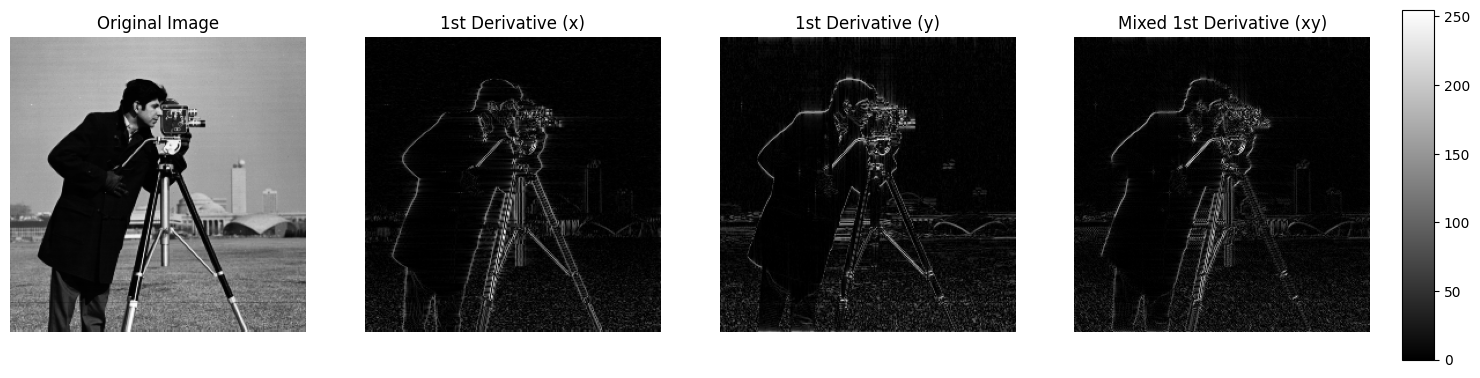

In [69]:
#3.3
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio
from scipy.fft import fft2, ifft2, fftshift, ifftshift

def frequency_derivative(image, order_x=1, order_y=1):
    """
    Compute the spatial derivatives of an image using frequency domain differentiation.
    :param image: Input grayscale image
    :param order_x: Order of derivative in x direction
    :param order_y: Order of derivative in y direction
    :return: Partial derivative of the image in the specified order
    """
    image = image.astype(np.float32)  # Convert image to float for numerical stability

    # Get image dimensions
    h, w = image.shape

    # Generate frequency domain coordinates
    u = np.fft.fftfreq(w) * w
    v = np.fft.fftfreq(h) * h
    U, V = np.meshgrid(u, v, indexing="xy")


    U[U == 0] = 1e-6
    V[V == 0] = 1e-6

    D_x = (1j * 2 * np.pi * U) * (order_x > 0)
    D_y = (1j * 2 * np.pi * V) * (order_y > 0)
    D = fftshift(D_x + D_y)

    F_image = fftshift(fft2(image))
    F_derivative = F_image * D
    derivative_image = np.real(ifft2(ifftshift(F_derivative)))

    # Normalize the output for visualization
    derivative_image = np.abs(derivative_image)
    derivative_image = derivative_image / np.max(derivative_image) * 255

    return derivative_image.astype(np.uint8)

image = iio.imread("../TestImages/Week 1/cameraman.tif")

derivative_x1_y0 = frequency_derivative(image, order_x=1, order_y=0)  # x
derivative_x0_y1 = frequency_derivative(image, order_x=0, order_y=1)  # y
derivative_x1_y1 = frequency_derivative(image, order_x=1, order_y=1)  # xy

fig, axes = plt.subplots(1, 4, figsize=(16, 5))

axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")

im1 = axes[1].imshow(derivative_x1_y0, cmap='gray')
axes[1].set_title("1st Derivative (x)")
axes[1].axis("off")

im2 = axes[2].imshow(derivative_x0_y1, cmap='gray')
axes[2].set_title("1st Derivative (y)")
axes[2].axis("off")

im3 = axes[3].imshow(derivative_x1_y1, cmap='gray')
axes[3].set_title("Mixed 1st Derivative (xy)")
axes[3].axis("off")

# colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im3, cax=cbar_ax)

fig.subplots_adjust(left=0.05, right=0.9, bottom=0.1, top=0.9, wspace=0.2)

plt.show()


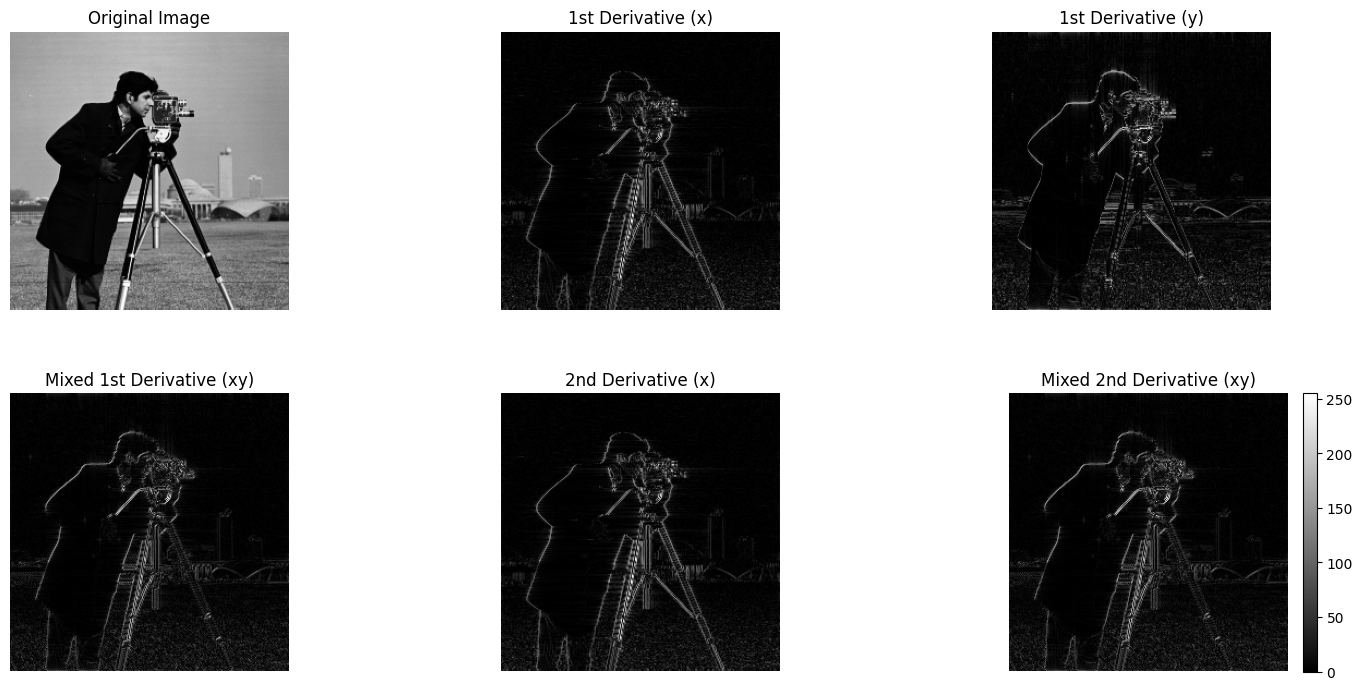

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from matplotlib.colors import Normalize

image = iio.imread("../TestImages/Week 1/cameraman.tif")

derivative_x1_y0 = frequency_derivative(image, order_x=1, order_y=0)  # x
derivative_x0_y1 = frequency_derivative(image, order_x=0, order_y=1)  # y
derivative_x1_y1 = frequency_derivative(image, order_x=1, order_y=1)  # xy
derivative_x2_y0 = frequency_derivative(image, order_x=2, order_y=0)  # x
derivative_x0_y2 = frequency_derivative(image, order_x=0, order_y=2)  # y
derivative_x2_y2 = frequency_derivative(image, order_x=2, order_y=2)  # xy

fig, axes = plt.subplots(2, 3, figsize=(16, 8))

axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title("Original Image")
axes[0, 0].axis("off")

axes[0, 1].imshow(derivative_x1_y0, cmap='gray', norm=Normalize(vmin=0, vmax=255))
axes[0, 1].set_title("1st Derivative (x)")
axes[0, 1].axis("off")

axes[0, 2].imshow(derivative_x0_y1, cmap='gray', norm=Normalize(vmin=0, vmax=255))
axes[0, 2].set_title("1st Derivative (y)")
axes[0, 2].axis("off")

axes[1, 0].imshow(derivative_x1_y1, cmap='gray', norm=Normalize(vmin=0, vmax=255))
axes[1, 0].set_title("Mixed 1st Derivative (xy)")
axes[1, 0].axis("off")

axes[1, 1].imshow(derivative_x2_y0, cmap='gray', norm=Normalize(vmin=0, vmax=255))
axes[1, 1].set_title("2nd Derivative (x)")
axes[1, 1].axis("off")

im3 = axes[1, 2].imshow(derivative_x2_y2, cmap='gray', norm=Normalize(vmin=0, vmax=255))
axes[1, 2].set_title("Mixed 2nd Derivative (xy)")
axes[1, 2].axis("off")

fig.colorbar(im3, ax=axes[1, 2], fraction=0.046, pad=0.04)

fig.subplots_adjust(left=0.05, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)

plt.show()
